In [1]:
import torch

device = torch.device("cpu")  # Force CPU usage
tensor = torch.tensor([1.0, 2.0, 3.0], device=device)
print(tensor.device)  # Should print 'cpu'


cpu


In [3]:
import os
import json
# import cv2
import easyocr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm

In [4]:
# Set paths
dataset_folder = "SROIE_filtered_dataset/"
image_folder = os.path.join(dataset_folder, "img")
entities_folder = os.path.join(dataset_folder, "entities")


In [15]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [16]:
# Function to perform OCR using EasyOCR
def extract_text(image_path):
    result = reader.readtext(image_path, detail=0)
    return " ".join(result).strip()

In [17]:
# Extract text from images
ocr_results = []
for filename in tqdm(os.listdir(image_folder)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_folder, filename)
        text = extract_text(image_path)
        ocr_results.append({"filename": filename, "text": text})

# Convert to DataFrame
df = pd.DataFrame(ocr_results)

100%|██████████| 281/281 [51:24<00:00, 10.98s/it] 


In [18]:
# Save to CSV
df.to_csv("receipt_transcripts.csv", index=False, encoding="utf-8")

In [5]:
# Load transcript from the csv file if you don't want to run OCR 
df = pd.read_csv("receipt_transcripts.csv")

In [6]:
# Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df["text"]).toarray()


In [23]:
# Apply K-Means Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

In [24]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

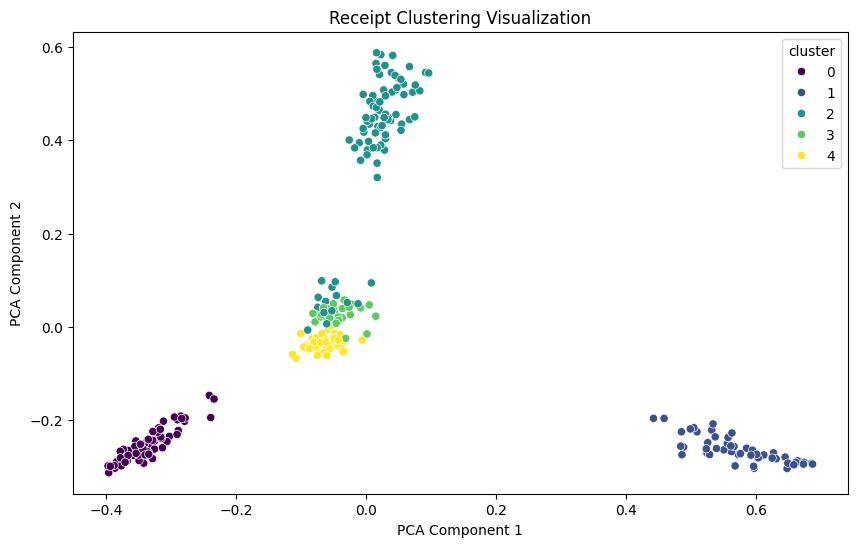

In [25]:
# Visualizing the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["pca1"], y=df["pca2"], hue=df["cluster"], palette="viridis")
plt.title("Receipt Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [24]:
# Save clustered results
df.to_csv("receipt_clusters.csv", index=False)
print("Clustering completed and results saved!")

Clustering completed and results saved!


In [10]:
# Evaluation using Silhouette Score
sil_score = silhouette_score(X, df["cluster"])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.18978830841481886


In [12]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(X, df["cluster"])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 2.050531090105923


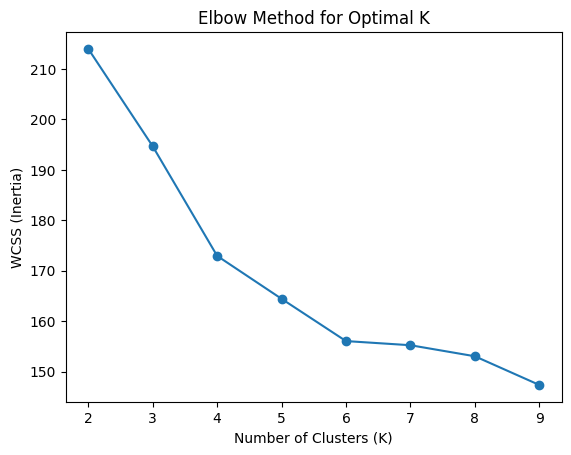

In [13]:
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal K")
plt.show()


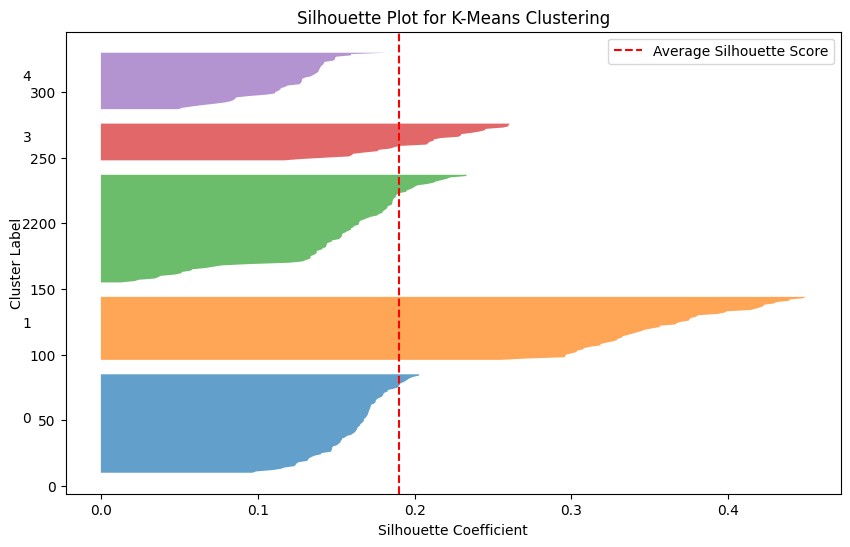

In [11]:
# Compute silhouette scores for each sample
silhouette_vals = silhouette_samples(X, df["cluster"])

# Plot silhouette visualization
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
for i in range(num_clusters):
    cluster_silhouette_vals = silhouette_vals[df["cluster"] == i]
    cluster_silhouette_vals.sort()
    
    y_upper = y_lower + len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))
    
    y_lower = y_upper + 10  # Space between clusters

# Plot settings
ax.axvline(silhouette_score(X, df["cluster"]), color="red", linestyle="--", label="Average Silhouette Score")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster Label")
ax.set_title("Silhouette Plot for K-Means Clustering")
plt.legend()
plt.show()